In [174]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from pandas import DataFrame as daf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
random.seed(10)
#Variance
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))

    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1


    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates

    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])

    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)




def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]

        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]

    return (n_values,tauhats,sehats,lb,ub)





def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

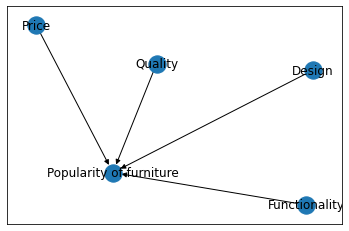

In [134]:
#DAG
graph = nx.DiGraph()
graph.add_edges_from([("Price", "Popularity of furniture"), ("Design", "Popularity of furniture"),("Quality", "Popularity of furniture"),("Functionality", "Popularity of furniture")])
k = plt.tight_layout()

nx.draw_networkx(graph, arrows=True)
# EXAMPLE :the Popularity of furniture is not only affected by its Price, but also affected by its Design, Quality, Functionality

# Q1:1: No covariates 


yi=t*Ti+ei

In [65]:
tau = 8
corr = .6
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████████████████████████████████████████████| 495/495 [00:07<00:00, 65.08it/s]


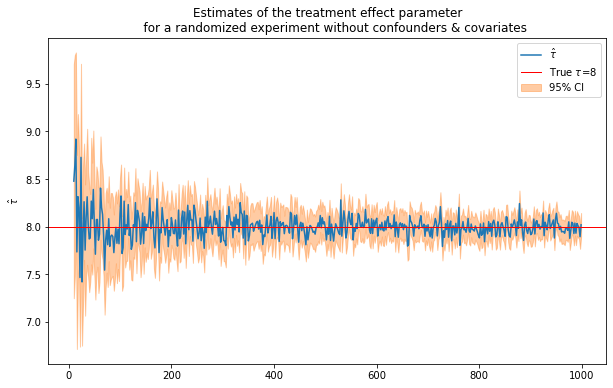

In [66]:
caption = """Estimates of the treatment effect parameter
    for a randomized experiment without confounders & covariates"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

In [135]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [136]:
tauhat,se_tauhat

(4.506401824962457, 0.22024476925383488)

In [137]:
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()

res.params[0], res.HC1_se[0]

(4.506401824962456, 0.22024476925383488)

In [71]:
#bias,RMSE and size:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.63it/s]


In [138]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.9719808447807547, RMSE=1.0128345076172656, size=0.9765
N=1000: bias=-0.9789869565240399, RMSE=1.0080281868773204, size=1.0


# Q1:2: Covariates
yi=t* Ti+beta* Xi+ei

In [139]:
tau = 8
corr = .6
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:10<00:00, 44.88it/s]


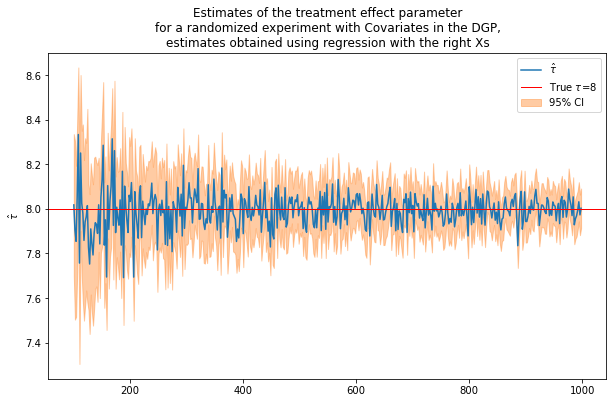

In [140]:
caption = """Estimates of the treatment effect parameter
for a randomized experiment with Covariates in the DGP,
estimates obtained using regression with the right Xs"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

In [141]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(7.9558219327608555, 0.20045165180406602)

In [142]:
# OLS:
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]

(7.9558219327608555, 0.20045165180406602)

In [143]:
# bias,RMSE and size:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 81.31it/s]


In [144]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print (f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.002118842167430694, RMSE=0.20103313517736474, size=0.055
N=1000: bias=-0.0005492953249994778, RMSE=0.06345711946112527, size=0.0515


# Q2:confounder

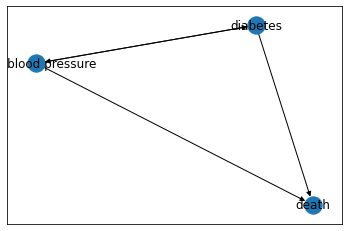

In [145]:
#DAG
graph = nx.DiGraph()
graph.add_edges_from([("diabetes", "death"),("high blood pressure","death"),("high blood pressure","diabetes"),("diabetes","high blood pressure")])
k = plt.tight_layout()

nx.draw_networkx(graph, arrows=True)

# Example: high blood pressure and diabetes will affect each other's severity and both of them will cause death

1: fail control for confounder:

In [146]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 
    corr = 0.5 # correlation for multivariate normal
    X = fn_generate_multnorm(N,corr,nvar)
    C = X[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.5*C+err
    Tab = T+0.5*C

    return (Yab,Tab,C)
tau = 4
corr = .75
p = 4
Y,T,C = fn_generate_data_conf(tau,N,p,corr)
#Run R Monte Carlo iterations and compute bias, RMSE and size¶
## Not control confounder
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.52it/s]


In [147]:
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-4.968149857249647, RMSE=4.97636193628604, size=1.0
N=1000: bias=-4.968039802567692, RMSE=4.9741062533110005, size=1.0


 2:control for confounder

In [148]:
#bias, RMSE and size:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:26<00:00, 76.78it/s]


In [149]:
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-3.9957008077662604, RMSE=3.9980784334261705, size=1.0
N=1000: bias=-4.000857745073414, RMSE=4.001119952746092, size=1.0


# Q3:Selection Bias

1:No selection bias

In [81]:
tau = 8
corr = .6
conf= True
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:12<00:00, 37.48it/s]


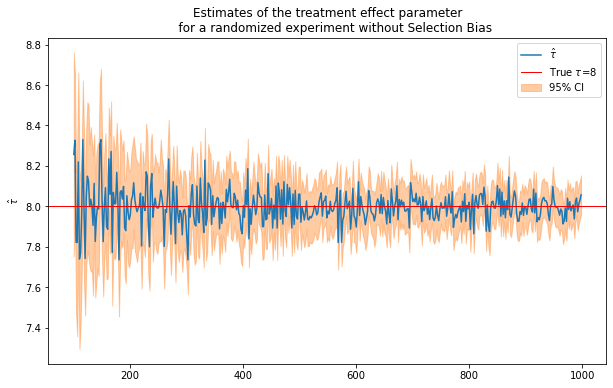

In [82]:
caption = """Estimates of the treatment effect parameter
    for a randomized experiment without Selection Bias"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

In [150]:
N = 100
Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf=True)
Yt = Yexp[np.where(T == 1)[0], :]
Yc = Yexp[np.where(T == 0)[0], :]
tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
lb = lb + [tauhat - 1.96 * se_tauhat]
ub = ub + [tauhat + 1.96 * se_tauhat]

tauhat, se_tauhat

(3.9040570443661786, 0.22534675246224267)

In [151]:
# OLS:
const = np.ones([N, 1])

model = sm.OLS(Yexp, np.concatenate([T, const], axis=1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(3.904057044366179, 0.22534675246224267)

In [85]:
#bias,RMSE and size:
estDict = {}
R = 2000
for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf)
        Yt = Yexp[np.where(T == 1)[0], :]
        Yc = Yexp[np.where(T == 0)[0], :]
        tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat': np.array(tauhats).reshape([len(tauhats), 1]),
        'sehat': np.array(sehats).reshape([len(sehats), 1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:27<00:00, 73.23it/s]


In [128]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.9719808447807547, RMSE=1.0128345076172656, size=0.9765
N=1000: bias=-0.9789869565240399, RMSE=1.0080281868773204, size=1.0


2:seletion bias

In [61]:
tau = 8
corr = .6
conf= True
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
flagX = 2
(nvalues4,tauhats4,sehats4,lb4,ub4) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

  0%|                                                                                          | 0/450 [00:00<?, ?it/s]C:\Users\lenovo\AppData\Local\Temp/ipykernel_16688/2386689493.py:129: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Xobs1 = X[:,:np.int(p0/2)]
C:\Users\lenovo\AppData\Local\Temp/ipykernel_16688/2386689493.py:130: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.

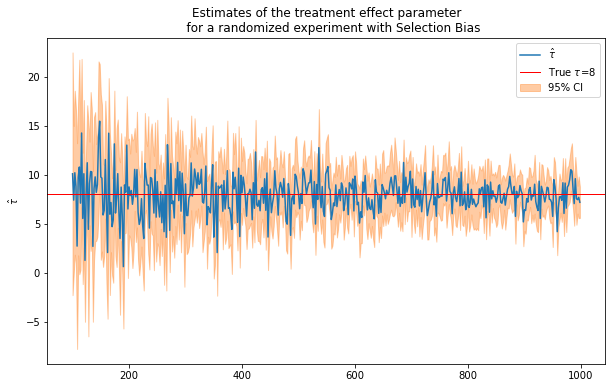

In [62]:
caption = """Estimates of the treatment effect parameter
    for a randomized experiment with Selection Bias"""
fn_plot_with_ci(nvalues4,tauhats4,tau,lb4,ub4,caption)

In [152]:
N = 100
Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf=True)
Yt = Yexp[np.where(T == 1)[0], :]
Yc = Yexp[np.where(T == 0)[0], :]
tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
lb = lb + [tauhat - 1.96 * se_tauhat]
ub = ub + [tauhat + 1.96 * se_tauhat]

tauhat, se_tauhat

(3.887627783854603, 0.22588531553611244)

In [153]:
#  OLS:
const = np.ones([N, 1])

model = sm.OLS(Yexp, np.concatenate([T, const], axis=1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(3.8876277838546036, 0.2258853155361124)

In [154]:
#bias,RMSE and size:
estDict = {}
R = 2000
for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf)
        Yt = Yexp[np.where(T == 1)[0], :]
        Yc = Yexp[np.where(T == 0)[0], :]
        tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat': np.array(tauhats).reshape([len(tauhats), 1]),
        'sehat': np.array(sehats).reshape([len(sehats), 1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 79.36it/s]


In [155]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0028900197790766163, RMSE=0.20097261630201402, size=0.054
N=1000: bias=-0.0019952746677099936, RMSE=0.0649468826005076, size=0.0515


DAG:

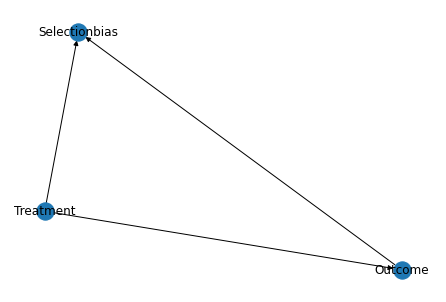

In [132]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Outcome')
G.add_node('s2', desc='Treatment')
G.add_node('s3', desc='Selectionbias')
G.add_edge('s2','s1')
G.add_edge('s1','s3')
G.add_edge('s2','s3')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

Example for question 3:

Suppose a research organization wants to study the topic of "whether hospitals can make people healthier". This organization randomly selected 100,000 people, measured the health level of these 100,000 people, and then divided the 100,000 people into two groups according to whether they had been to the hospital in the last year, and the statistical results were that the health level of the group that had not been to the hospital in the last year was better than that of the group that had been to the hospital, and we cannot say that hospitals make people less healthy!

